# GoogLeNet论文复现

## **GoogLeNet的主要特点**

GoogLeNet是由Google提出的一种深度卷积神经网络架构，它的主要特点包括：

1. **Inception模块**：
   - GoogLeNet的核心创新是引入了Inception模块。该模块通过在同一层上并行执行多种卷积操作（如不同大小的卷积核）和池化操作，以捕获不同尺度的特征。
   - 每个Inception模块包含多个卷积层（不同卷积核尺寸）和池化层（最大池化与平均池化），并通过1x1卷积进行特征压缩和维度匹配。

2. **1x1卷积**：
   - Inception模块中使用了大量的1x1卷积层，它可以用来减少计算量和参数数量。
   - 1x1卷积被用于降低维度和进行特征融合，使得模型在保持高效性的同时，能够捕获更丰富的特征。

3. **深度可分离卷积（Depthwise Separable Convolutions）**：
   - 在网络的设计中，GoogLeNet使用了深度可分离卷积，减少了卷积操作的计算量，并提高了模型的效率。

4. **全局平均池化**：
   - GoogLeNet采用了全局平均池化（Global Average Pooling）来代替传统的全连接层，从而减少了模型的参数数量，降低了过拟合的风险。

5. **更深的网络结构**：
   - 相比于AlexNet和VGG，GoogLeNet具有更深的网络架构，但通过高效的Inception模块，保持了计算效率。

---

## **GoogLeNet的优势**

1. **高效性**：
   - GoogLeNet通过使用Inception模块以及1x1卷积，大大减少了计算量和参数数量，从而在处理大规模数据时提高了效率。

2. **较少的参数**：
   - 相比于VGG等网络，GoogLeNet具有较少的参数，避免了过多的计算负担，同时仍然保持较高的准确率。

3. **深度与多尺度特征学习**：
   - 通过Inception模块，GoogLeNet能够同时从多个尺度提取特征，使得模型更具表达能力。

4. **全局平均池化**：
   - 使用全局平均池化代替全连接层，有效减少了模型参数数量，并提高了计算效率。

---

## **GoogLeNet的劣势**

1. **网络结构较为复杂**：
   - GoogLeNet的Inception模块和深度结构较为复杂，可能使得网络在训练时的调优和优化较为困难。

2. **可解释性较差**：
   - 由于Inception模块和深度结构的复杂性，GoogLeNet的可解释性较差，难以直观理解每个模块的作用。

---

## **GoogLeNet的架构**

GoogLeNet的架构可以简化为以下几个关键部分：

- **输入**：
  - 输入大小为224x224x3的图像。
  
- **Inception模块**：
  - 网络的核心由多个Inception模块堆叠组成，每个模块包含多个并行的卷积操作和池化操作。
  
- **全局平均池化**：
  - 在最后一层使用全局平均池化来替代全连接层，从而减少参数数量。

- **输出**：
  - 输出层为一个softmax分类器，用于进行多类分类。

---

## **GoogLeNet的架构图**：

### **Inception Module:**
<img src="img/Inception_Module.png">

### **Whole Structure:**
<img src="img/Whole_Structure.png">

---

## **GoogLeNet架构总结**

GoogLeNet通过Inception模块、高效的1x1卷积以及全局平均池化设计，成功地提高了计算效率和减少了参数数量，具有较强的多尺度特征提取能力，但在实现上相对较为复杂。


## GoogLeNet的代码实现

### 1. 必要库的导入

In [1]:
import os
import sys
import torch
from PIL import Image
import numpy as np
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 获取当前文件的父目录
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'),'..'))
# 如果父目录不在 sys.path中，则添加
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import utils
    
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.mps.is_available()
                      else 'cpu')
print(torch.__version__)
print(device)

2.6.0
mps


### 2.导入数据库并转换为DataLoader格式

在这一部分中，我们使用torchvision.transforms 仿照原论文对图像进行预处理：
- `Resize` 和 `CenterCrop`：调整图像大小以匹配模型输入。
- `ToTensor`：将图像转换为张量。
- `Normalize`：对像素值进行归一化，有助于模型更快收敛。
- 在训练集中用 `RandomHorizontalFlip`使得图像随机水平翻转，增强图像

⚠️ **初学者提示**：
- 确保 `mean` 和 `std` 值与预训练模型使用的值一致。
- 输入图像的大小应与模型期望的输入大小匹配。

In [2]:
# GoogLeNet原论文的预处理流程
transform = {'train':transforms.Compose([
    transforms.Resize(256),                    # 缩放图像，使得最短边为256像素
    transforms.RandomCrop(224),                # 中心裁剪224x224
    transforms.RandomHorizontalFlip(),         # 随机水平翻转
    transforms.ToTensor(),                     # 转换为Tensor，并缩放到[0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # 按ImageNet均值和标准差归一化
                         std=[0.229, 0.224, 0.225])]),
             'val':transforms.Compose([
    transforms.Resize(256),                    # 缩放图像，使得最短边为256像素
    transforms.CenterCrop(224),                # 中心裁剪224x224
    transforms.ToTensor(),                     # 转换为Tensor，并缩放到[0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # 按ImageNet均值和标准差归一化
                         std=[0.229, 0.224, 0.225])])}


In [3]:
# 读取验证集的标签
val_labels = {}
with open('../Datasets/tiny-imagenet-200/val/val_annotations.txt') as f:
    for line in f:
        parts = line.strip().split('\t')
        filename, label = parts[0], parts[1]
        val_labels[filename] = label
print(val_labels['val_0.JPEG'])

# 首先将训练数据集加载到DataLoader中
ImageNet_train = datasets.ImageFolder(root='../Datasets/tiny-imagenet-200/train',transform=transform['train'])
ImageNet_train_iter = DataLoader(ImageNet_train,batch_size=64,shuffle=True,num_workers=0)

# 自定义验证集数据集
class TinyImageNetValDataset(Dataset):
    def __init__(self, img_dir, val_labels, transform=None):
        self.img_dir = img_dir
        self.img_dict = val_labels
        self.transform = transform
        self.classes = sorted(list(set(self.img_dict.values())))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.img_list = list(self.img_dict.keys())

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.img_dict[img_name]]

        if self.transform:
            image = self.transform(image)
        return image, label
    
ImageNet_val = TinyImageNetValDataset(
    img_dir='../Datasets/tiny-imagenet-200/val/images',
    val_labels=val_labels,
    transform=transform['val'])
ImageNet_val_iter = DataLoader(ImageNet_val, batch_size=64, shuffle=False, num_workers=0)

n03444034


In [4]:
# 尝试输出两个DataLoader中的第一批张量的形状
img_train = next(iter(ImageNet_train_iter))
print(len(img_train))
print(img_train[0].shape)
print(img_train[1].shape)
print(img_train[1])

img_val = next(iter(ImageNet_val_iter))
print(len(img_val))
print(img_val[0].shape)
print(img_val[1].shape)
print(img_val[1])

2
torch.Size([64, 3, 224, 224])
torch.Size([64])
tensor([ 25,  55, 182,  47, 150,  86,  26, 145,  73,  62, 155, 110, 174, 194,
        179, 103,  89,  94,  84, 121,  31,  91,  90,  71,  73,  66, 177,  31,
        119, 155, 152,  98, 167,  37, 177, 138,  76, 136,  60,  52,  31,  81,
          8, 148, 126,  37, 139, 145, 161, 114,  20, 179, 130, 184,  82, 121,
         71, 190,  87, 190,  52,  93, 196,  79])
2
torch.Size([64, 3, 224, 224])
torch.Size([64])
tensor([107, 139, 140,  69,  69, 161, 147,  73, 145,  39, 158, 188,  39, 120,
         21,  79,  33, 165, 153, 119, 123, 124,  18,   1, 170, 141, 171, 158,
         79,  25, 121, 179, 124, 130, 176,  86,   6, 129, 142, 127,  33,  33,
         44,  40, 110,  40, 159, 184,  57,  80,   9,  34,  39,  14,  75, 199,
         10,  99,  66, 160,  69, 177,  25, 101])


### 3. **Inception Module的构建规律**

Inception模块是GoogLeNet的核心创新之一，它通过并行计算不同尺寸的卷积和池化操作，从而捕捉不同尺度的特征。Inception模块的主要思想是通过组合不同类型的卷积和池化操作，来增强网络的表达能力，并在保持计算效率的同时提高性能。

---

#### **1. 核心设计理念**
- **多尺度特征提取：** 在同一层中并行使用不同大小的卷积核和池化操作，来捕捉不同尺度的图像特征。
- **1x1卷积：** 使用1x1卷积来减少计算量和参数数量，同时进行维度压缩和特征融合。
- **并行结构：** 将不同大小的卷积操作（如1x1, 3x3, 5x5）和池化操作（如最大池化和平均池化）并行组合，获取不同尺度的特征。

---

#### **2. Inception模块的具体构成**

Inception模块一般包括以下几种操作，每种操作都具有不同的卷积核大小或池化方式：

- **1x1卷积：** 用于减少输入特征图的深度（即通道数），从而减少计算量。
- **3x3卷积：** 用来捕捉较小尺度的特征，通常与1x1卷积结合使用以降低计算复杂度。
- **5x5卷积：** 用来捕捉更大尺度的特征，通常也会先使用1x1卷积来减少通道数。
- **最大池化（Max Pooling）：** 用于提取局部特征，通常与1x1卷积结合进行特征降维。
- **平均池化（Average Pooling）：** 用于降维和捕捉图像的全局信息。

---

#### **3. Inception模块的具体步骤**

1. **输入：** 输入特征图尺寸为 \( W \times H \times D \)（宽度 x 高度 x 深度）。
2. **1x1卷积：** $Y_{1} = Conv1\times1(X)$
3. **3x3卷积：** $Y_{2} = Conv3\times3(Conv1\times1(X))$
4. **5x5卷积：** $Y_{3} = Conv5\times5(Conv1\times1(X))$
5. **最大池化：** $Y_{4} = MaxPool(Conv1\times1(X)$
6. **输出拼接：** $Y = [Y_{1},Y_{2},Y_{3},Y_{4}]$

---

#### **4. Inception模块的优化**
- **1x1卷积的使用：** 降低通道数，减少计算量。
- **并行结构：** 同时考虑局部和全局的图像信息。
- **减少计算量：** 显著减少计算量和参数数量。

---

#### **5. 典型的Inception模块示意图**

Inception模块通常包含如下几个部分：

- 1x1卷积
- 1x1卷积 -> 3x3卷积
- 1x1卷积 -> 5x5卷积
- 3x3最大池化 -> 1x1卷积

这些操作并行进行，然后将它们的输出在通道维度上进行拼接。

**再放一遍Inception_Module的图，加深印象**
<img src="img/Inception_Module.png">

In [2]:
class InceptionModule(nn.Module):
    def __init__(self,in_channels,out_1,mid_2,out_2,mid_3,out_3,out_4):
        super().__init__()
               
        # 1x1卷积层的定义
        self.Y1 = nn.Conv2d(in_channels,out_1,kernel_size=1)
        
        # 1x1 -> 3x3卷积层的定义
        self.Y2 = nn.Sequential(
            nn.Conv2d(in_channels,mid_2,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(mid_2,out_2,kernel_size=3,padding=1),
            nn.ReLU())
        
        # 1x1 -> 5x5卷积层的定义
        self.Y3 = nn.Sequential(
            nn.Conv2d(in_channels,mid_3,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(mid_3,out_3,kernel_size=5,padding=2),
            nn.ReLU())
        
        # 3x3 MaxPool -> 1x1 卷积层的定义
        self.Y4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels,out_4,kernel_size=1),
            nn.ReLU())
        
    # 利用前向函数forward来拼接四个输出
    def forward(self,x):
        branch_1 = self.Y1(x)
        branch_2 = self.Y2(x)
        branch_3 = self.Y3(x)
        branch_4 = self.Y4(x)
        out = torch.cat([branch_1,branch_2,branch_3,branch_4],dim=1)
        return out

# 检验一下输出形状是否正确
model = InceptionModule(3,64,64,128,32,128,32)
input_tensor = torch.randn(1, 3, 224, 224)
output_tensor = model(input_tensor)
print(output_tensor.shape)
# 输出的总的通道数应该是上面四个卷积层的out_channels相加 64+128+128+32=352

torch.Size([1, 352, 224, 224])


### 4. 搭建GoogLeNet神经网络模型
实际上我们完全可以定义一个比较通用的GoogLeNet模型，通过传入参数设置网络的深度和广度

In [3]:
# 定义完整的GoogLeNet架构
class GoogLeNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, ceil_mode=True),
            # 你会发现这实际上是两个小的VGG块，在此我们不做单独定义
            nn.Conv2d(64, 64, kernel_size=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, ceil_mode=True))

        self.Google_1 = nn.Sequential(
            InceptionModule(192, 64, 96, 128, 16, 32, 32), # 输出通道数：64+128+32+32=256
            InceptionModule(256, 128, 128, 192, 32, 96, 64), # 输出通道数：128+192+96+64=480
            nn.MaxPool2d(3, stride=2, ceil_mode=True))

        self.Google_2 = nn.Sequential(
            InceptionModule(480, 192, 96, 208, 16, 48, 64), # 输出通道数：192+208+48+64=512
            InceptionModule(512, 160, 112, 224, 24, 64, 64),
            InceptionModule(512, 128, 128, 256, 24, 64, 64),
            InceptionModule(512, 112, 144, 288, 32, 64, 64),
            InceptionModule(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, stride=2, ceil_mode=True))

        self.Google_3 = nn.Sequential(
            InceptionModule(832, 256, 160, 320, 32, 128, 128),
            InceptionModule(832, 384, 192, 384, 48, 128, 128))

        self.classifier_1 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # 将7*7特征图池化为单一向量
            nn.Dropout(0.4)) # 防止过拟合
        
        self.classifier_2 = nn.Linear(1024, num_classes) # 最终分类

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.Google_1(x)
        x = self.Google_2(x)
        x = self.Google_3(x)
        x = self.classifier_1(x)
        x = torch.flatten(x,1)
        x = self.classifier_2(x)
        return x

net = GoogLeNet(200)
# 看一下壮观的GoogLeNet~
print(net)

GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (Google_1): Sequential(
    (0): InceptionModule(
      (Y1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (Y2): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (Y3): Sequential(
        (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        

感觉有些迷糊？没关系，用torchinfo中的summary模块可以看到一个固定形状的tensor经过每一个模块之后的形状变化！

In [37]:
summary(net,input_size=(3,224,224),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
            Conv2d-5          [-1, 192, 56, 56]         110,784
              ReLU-6          [-1, 192, 56, 56]               0
         MaxPool2d-7          [-1, 192, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          12,352
            Conv2d-9           [-1, 96, 28, 28]          18,528
             ReLU-10           [-1, 96, 28, 28]               0
           Conv2d-11          [-1, 128, 28, 28]         110,720
             ReLU-12          [-1, 128, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           3,088
             ReLU-14           [-1, 16,

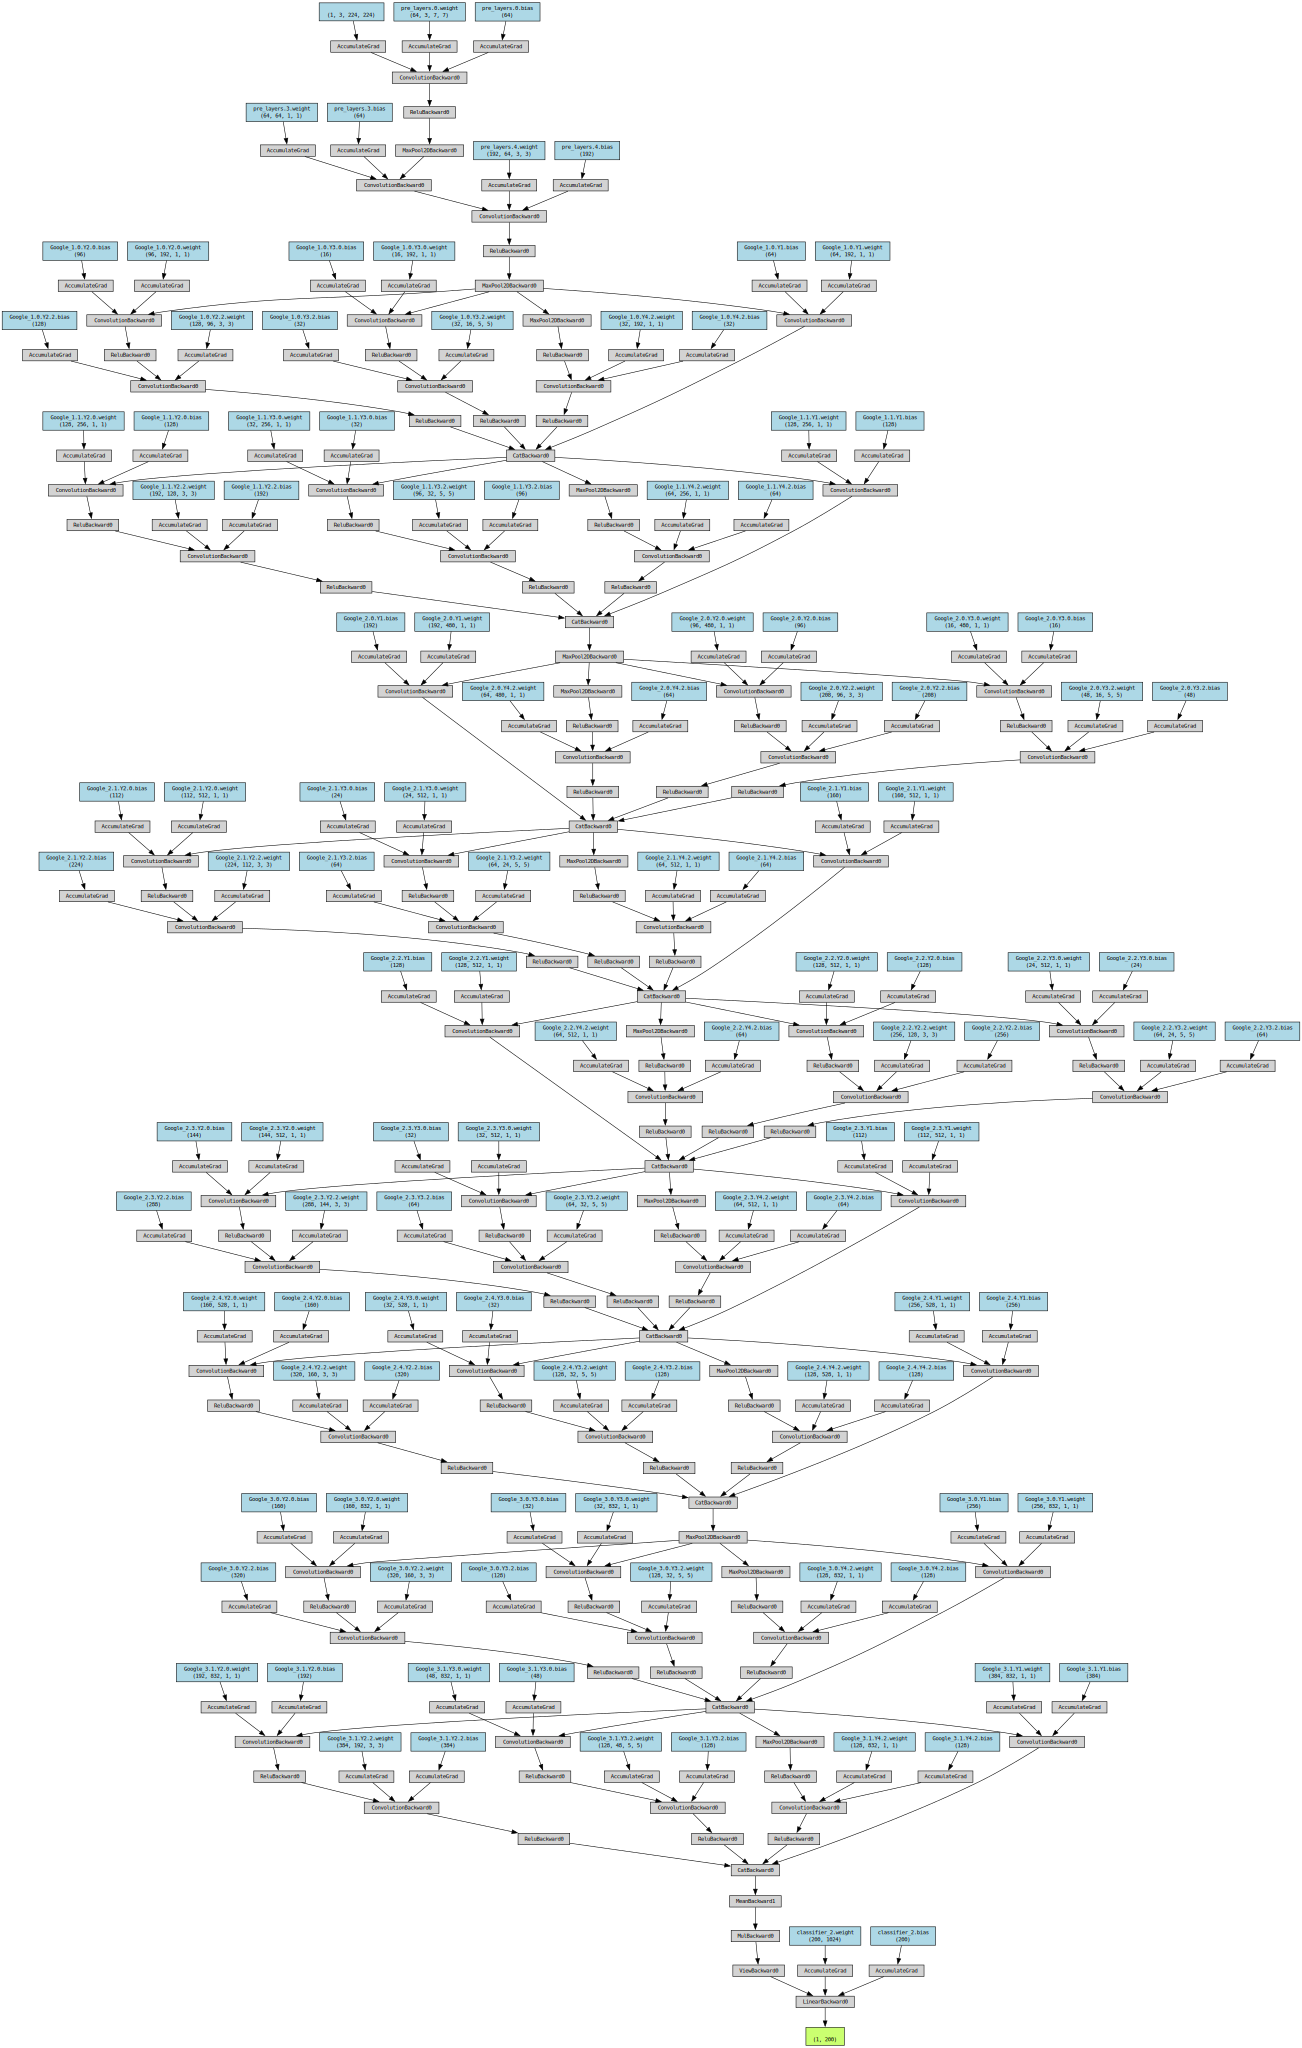

In [5]:
from torchviz import make_dot
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'  # M1/M2 Mac

x = torch.rand(1, 3, 224, 224).to(device).requires_grad_(True)
model = net.to(device)
y = model(x)
MyConvNetVis = make_dot(y, params=dict(model.named_parameters()))
MyConvNetVis.format = "png"
MyConvNetVis.render("GoogLeNet", format="png")
MyConvNetVis

### 5. Run it!

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(),lr=0.001)

In [ ]:
utils.trianing_loop(net,loss_fn,optimizer,ImageNet_train_iter,ImageNet_val_iter,15,device)